## **Jailbreaking Deep Models: Adversarial Attacks on ResNet-34 Classifiers**
#### **-by Team DL NCR**
#### Amaan Elahi , Karan Allagh , Mohammad Maaz Rashid

In [ ]:
import os
import sys
import random
import shutil
import json
import warnings
import re
import subprocess
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from PIL import Image

# reproducibility
SEED = 2025
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# paths and constants
RAW_PATH    = Path("TestDataSet")
LABEL_JSON  = RAW_PATH / "label_map.json"
SUBSET_PATH = Path("IMNET100_subset")
PER_CLASS   = 5

# helper to install datasets if needed
def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=True)

# ─────────── 1. Load ImageNet1K index ───────────
IDX_JSON = Path("imagenet_class_index.json")
if not IDX_JSON.exists():
    import urllib.request
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/tutorials/master/_static/imagenet_class_index.json",
        IDX_JSON
    )
idx_raw  = json.loads(IDX_JSON.read_text())
WNID2IDX = {v[0]: int(k) for k,v in idx_raw.items()}

# build ENG→WNID and CANON2WNID
ENG2WNID = {}
for wnid, eng in (v for v in idx_raw.values()):
    ENG2WNID[eng.lower()] = wnid
    for tok in eng.split(","):
        ENG2WNID[tok.strip().lower()] = wnid
canon = lambda s: re.sub(r"[^a-z]", "", s.lower())
CANON2WNID = {canon(k):v for k,v in ENG2WNID.items()}

# create subset directory if needed
if not (RAW_PATH.exists() and any(RAW_PATH.iterdir())):
    RAW_PATH.mkdir(exist_ok=True)
    pip_install("datasets>=2.19.0")
    from datasets import load_dataset
    ds = load_dataset("clane9/imagenet-100", split="validation", trust_remote_code=True)
    tmp = Path("tmp_imnet100"); tmp.mkdir(exist_ok=True)
    for i, rec in enumerate(tqdm(ds, desc="HF download")):
        eng_full = ds.info.features["label"].names[rec["label"]]
        first    = eng_full.split(',')[0]
        key      = canon(first)
        wnid     = CANON2WNID.get(key)
        if wnid is None:
            warnings.warn(f"⚠️ skipping unknown '{eng_full}'")
            continue
        (tmp/wnid).mkdir(exist_ok=True)
        rec["image"].save(tmp/wnid/f"{i:05d}.png")
    tmp.rename(RAW_PATH)
    print("✅ HF download complete.")

# ─────────── 2. label_map.json & subset ───────────
label_map = {
    wnid: WNID2IDX[wnid]
    for wnid in sorted(CANON2WNID.values())
    if (RAW_PATH/wnid).is_dir()
}
LABEL_JSON.write_text(json.dumps(label_map, indent=2))
print(f"📝 Wrote label_map.json ({len(label_map)} classes)")

if not SUBSET_PATH.exists():
    SUBSET_PATH.mkdir()
    for wnid in sorted(label_map):
        imgs = sorted((RAW_PATH/wnid).glob("*"))
        random.shuffle(imgs)
        tgt = SUBSET_PATH/wnid; tgt.mkdir(exist_ok=True)
        for im in imgs[:PER_CLASS]:
            shutil.copy(im, tgt/im.name)
    print(f"✅ Built subset ({PER_CLASS*len(label_map)} images)")

Running on cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

train-00000-of-00017.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00001-of-00017.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00002-of-00017.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00003-of-00017.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00005-of-00017.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00006-of-00017.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

train-00007-of-00017.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00008-of-00017.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00009-of-00017.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00010-of-00017.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00011-of-00017.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00012-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00013-of-00017.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00014-of-00017.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00015-of-00017.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00016-of-00017.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126689 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

HF download:   0%|          | 0/5000 [00:00<?, ?it/s]

✅ HF download complete.
📝 Wrote label_map.json (100 classes)
✅ Built subset (500 images)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 226MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 225MB/s]


[T1] Clean → Top‑1 69.20% | Top‑5 90.60%
[T2] FGSM → Top‑1 3.20% | Top‑5 18.40%


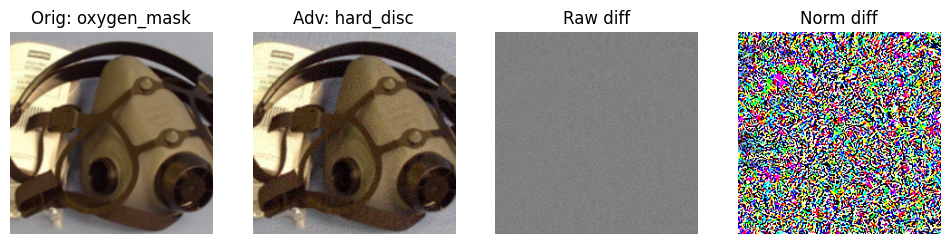

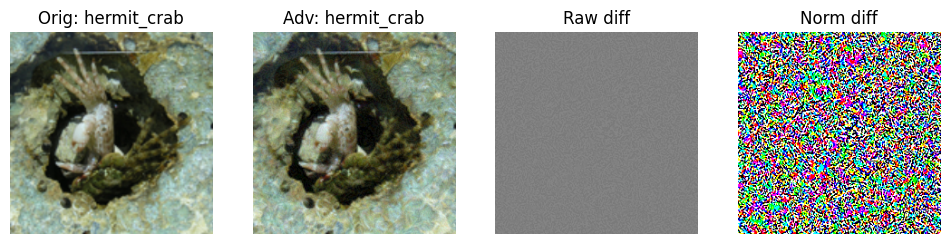

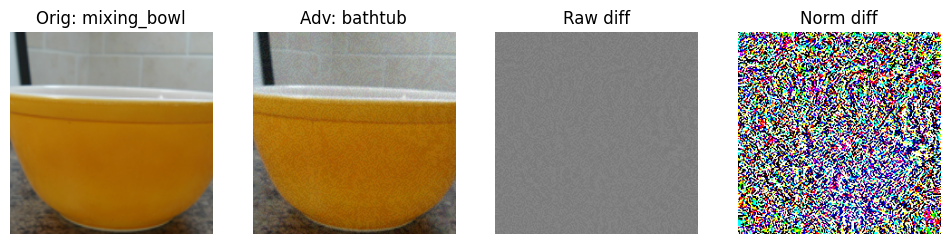

[T3] DI‑PGD → Top‑1 0.00% | Top‑5 2.40%


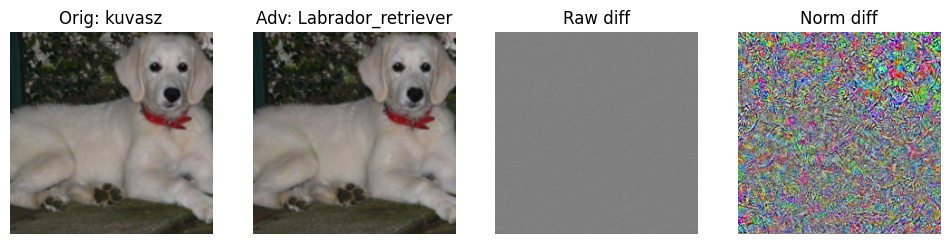

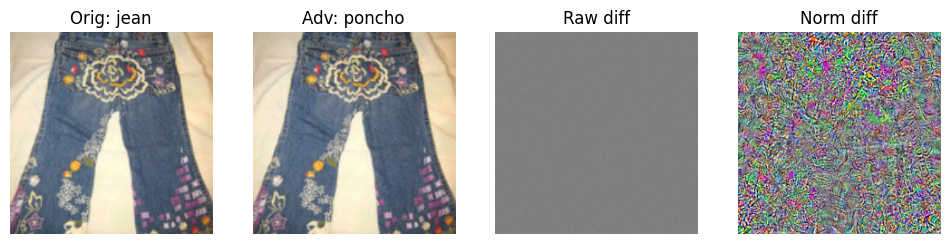

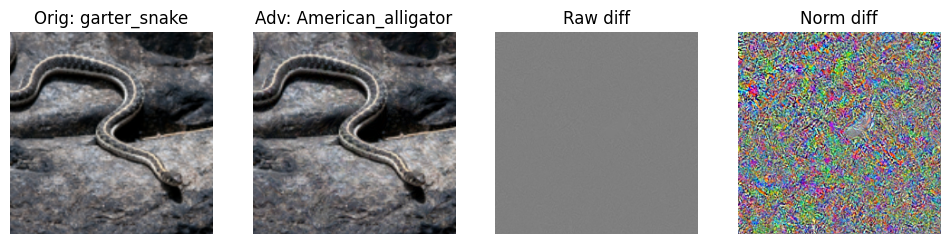

[T4] Patch‑RS → Top‑1 0.00% | Top‑5 7.00%


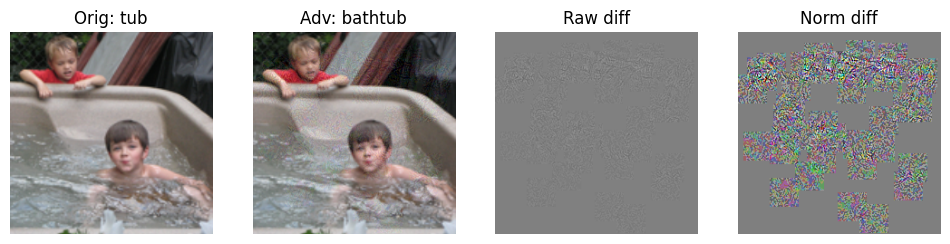

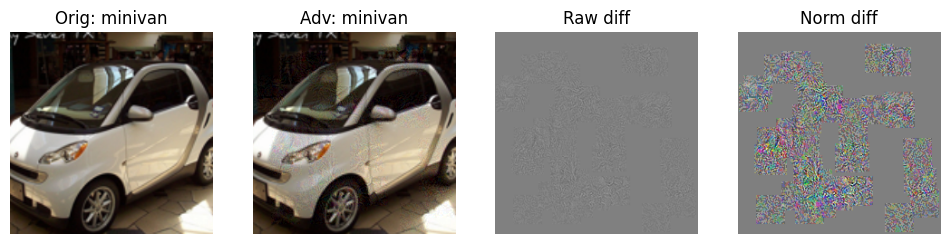

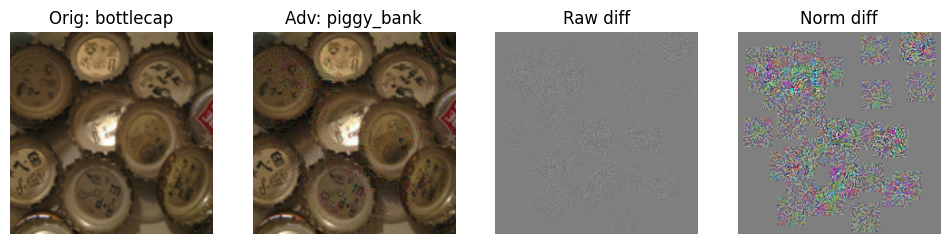


Transfer to DenseNet‑121:
 Clean  → 70.20% | 89.80%
 FGSM   → 33.80% | 68.40%
 DI‑PGD → 30.00% | 72.60%
 Patch  → 33.80% | 72.60%


In [ ]:
import os
import random
import shutil
import json
import warnings
import re
import subprocess
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt

# reproducibility
SEED = 2025
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure output directories
for d in ("AdvTest1", "AdvTest2", "AdvTest3"):
    Path(d).mkdir(parents=True, exist_ok=True)

# paths & constants
RAW_PATH    = Path("TestDataSet")
LABEL_JSON  = RAW_PATH / "label_map.json"
SUBSET_PATH = Path("IMNET100_subset")
PER_CLASS   = 5

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=True)

# 1. Load ImageNet‑1k index
IDX_JSON = Path("imagenet_class_index.json")
if not IDX_JSON.exists():
    import urllib.request
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/tutorials/master/_static/imagenet_class_index.json",
        IDX_JSON
    )
with open(IDX_JSON, "r") as f:
    idx_raw = json.load(f)

# build mappings
WNID2IDX = {v[0]: int(k) for k, v in idx_raw.items()}
IDX2WNID = {int(k): v[0] for k, v in idx_raw.items()}
WNID2ENG = {v[0]: v[1] for v in idx_raw.values()}

# build quick lookup for HF download
ENG2WNID = {}
for wnid, eng in idx_raw.values():
    ENG2WNID[eng.lower()] = wnid
    for tok in eng.split(","):
        ENG2WNID[tok.strip().lower()] = wnid
canon = lambda s: re.sub(r"[^a-z]", "", s.lower())
CANON2WNID = {canon(k): v for k, v in ENG2WNID.items()}

# 2. HF download
if not (RAW_PATH.exists() and any(RAW_PATH.iterdir())):
    RAW_PATH.mkdir(exist_ok=True)
    pip_install("datasets>=2.19.0")
    ds = load_dataset("clane9/imagenet-100", "validation", trust_remote_code=True)
    tmp = Path("tmp_imnet100"); tmp.mkdir(exist_ok=True)
    for i, rec in enumerate(tqdm(ds, desc="HF download")):
        eng = ds.info.features["label"].names[rec["label"]]
        wnid = CANON2WNID.get(canon(eng.split(",")[0]))
        if wnid is None:
            warnings.warn(f"skipping {eng}")
            continue
        (tmp/wnid).mkdir(exist_ok=True)
        rec["image"].save(tmp/wnid/f"{i:05d}.png")
    tmp.rename(RAW_PATH)

# 3. label_map & subset
label_map = {wnid: WNID2IDX[wnid] for wnid in sorted(CANON2WNID.values()) if (RAW_PATH/wnid).is_dir()}
with open(LABEL_JSON, "w") as f:
    json.dump(label_map, f, indent=2)

if not SUBSET_PATH.exists():
    SUBSET_PATH.mkdir()
    for wnid in sorted(label_map):
        imgs = sorted((RAW_PATH/wnid).glob("*"))
        random.shuffle(imgs)
        tgt = SUBSET_PATH/wnid; tgt.mkdir(exist_ok=True)
        for im in imgs[:PER_CLASS]:
            shutil.copy(im, tgt/im.name)

# 4. DataLoader & transforms
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
T = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class Sub100(ImageFolder):
    def __getitem__(self, idx):
        p, _ = self.samples[idx]
        p = Path(p)
        x = T(self.loader(str(p)))
        y = label_map[p.parent.name]
        return x, y

ds = Sub100(SUBSET_PATH)
dl = DataLoader(ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

all_x, all_y = [], []
for xb, yb in dl:
    all_x.append(xb); all_y.append(yb)
X = torch.cat(all_x).to(device)
Y = torch.cat(all_y).to(device)

# 5. Models & eval
res34 = models.resnet34(weights="IMAGENET1K_V1").to(device).eval()
dn121 = models.densenet121(weights="IMAGENET1K_V1").to(device).eval()

def topk_acc(logits, y, k):
    _, pred = logits.topk(k, dim=1)
    return (pred.eq(y.view(-1,1))).any(dim=1).float().mean().item()

def evaluate(model, src):
    t1 = t5 = cnt = 0
    it = src if isinstance(src, DataLoader) else DataLoader(src, batch_size=64)
    with torch.no_grad():
        for xb, yb in it:
            xb, yb = xb.to(device), yb.to(device)
            b = xb.size(0)
            out = model(xb)
            t1 += topk_acc(out, yb, 1) * b
            t5 += topk_acc(out, yb, 5) * b
            cnt += b
    return t1/cnt, t5/cnt

inv_norm = transforms.Normalize(
    [-m/s for m,s in zip(mean,std)],
    [1/s    for s in std]
)

def inv_tensor(t):
    return inv_norm(t).clamp(0,1)

def idx_to_name(idx):
    wnid = IDX2WNID[idx]
    return WNID2ENG[wnid]

def show_four(i, adv_batch):
    adv = adv_batch.detach()
    orig = transforms.ToPILImage()(inv_tensor(X[i].cpu()))
    advp = transforms.ToPILImage()(inv_tensor(adv[i].cpu()))
    # raw diff grayscale
    raw = (np.array(advp).astype(int) - np.array(orig).astype(int)).mean(2)
    raw_vis = (np.clip(raw + 128, 0, 255)).astype(np.uint8)
    dr = Image.fromarray(raw_vis).convert("RGB")
    # norm diff color
    diff = inv_tensor(adv[i].cpu()) - inv_tensor(X[i].cpu())
    mx = diff.abs().max()
    col = ((diff / mx) / 2 + 0.5).permute(1,2,0).numpy()
    col_vis = (np.clip(col, 0, 1) * 255).astype(np.uint8)
    dc = Image.fromarray(col_vis)
    # preds
    with torch.no_grad():
        oidx = res34(X[i].unsqueeze(0)).argmax(1).item()
        aidx = res34(adv[i].unsqueeze(0)).argmax(1).item()
    ol, al = idx_to_name(oidx), idx_to_name(aidx)
    fig, axes = plt.subplots(1,4,figsize=(12,3))
    for ax, img, ttl in zip(
        axes,
        [orig, advp, dr, dc],
        [f"Orig: {ol}", f"Adv: {al}", "Raw diff", "Norm diff"]
    ):
        ax.imshow(img); ax.set_title(ttl); ax.axis("off")
    plt.show()

# 6. Task 1
c1_1, c1_5 = evaluate(res34, dl)
print(f"[T1] Clean → Top‑1 {c1_1*100:.2f}% | Top‑5 {c1_5*100:.2f}%")

# 7. Task 2: FGSM
def fgsm(model, x, y, eps=0.02):
    x_adv = x.clone().detach().requires_grad_(True)
    F.cross_entropy(model(x_adv), y).backward()
    eps_norm = eps / torch.tensor(std, device=device).view(3,1,1)
    adv = x_adv + eps_norm * x_adv.grad.sign()
    lo = (0 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    hi = (1 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    return adv.clamp(lo, hi)

adv1 = fgsm(res34, X, Y, 0.02).detach()
raw_diff1 = ((adv1 - X).abs() * torch.tensor(std,device=device).view(3,1,1)).view(X.size(0), -1).max(1)[0]
assert (raw_diff1 <= 0.02 + 1e-6).all(), "FGSM L∞ violated"

for i, img in enumerate(adv1.cpu()):
    transforms.ToPILImage()(inv_tensor(img)).save(f"AdvTest1/{i:04d}.png")

a1_1, a1_5 = evaluate(res34, TensorDataset(adv1.cpu(), Y.cpu()))
print(f"[T2] FGSM → Top‑1 {a1_1*100:.2f}% | Top‑5 {a1_5*100:.2f}%")
for idx in random.sample(range(X.size(0)), 3):
    show_four(idx, adv1)

# 8. Task 3: DI‑PGD
def di_pgd(model, x, y, eps, alpha, steps, prob=0.7):
    ori = x.clone()
    adv = ori.clone().detach().requires_grad_(True)
    eps_norm = eps / torch.tensor(std,device=device).view(3,1,1)
    lo = (0 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    hi = (1 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    for _ in range(steps):
        inp = adv
        if random.random() < prob:
            s = random.randint(200,256)
            inp = F.interpolate(adv, (s,s)); inp = F.interpolate(inp, (224,224))
        F.cross_entropy(model(inp), y).backward()
        adv = (adv + alpha * adv.grad.sign()).clamp(lo, hi)
        adv = torch.min(torch.max(adv, ori - eps_norm), ori + eps_norm).detach().requires_grad_(True)
    return adv

adv2 = di_pgd(res34, X, Y, 0.02, 0.005, 20).detach()
raw_diff2 = ((adv2 - X).abs() * torch.tensor(std,device=device).view(3,1,1)).view(X.size(0), -1).max(1)[0]
assert (raw_diff2 <= 0.02 + 1e-6).all(), "DI‑PGD L∞ violated"

for i, img in enumerate(adv2.cpu()):
    transforms.ToPILImage()(inv_tensor(img)).save(f"AdvTest2/{i:04d}.png")

b2_1, b2_5 = evaluate(res34, TensorDataset(adv2.cpu(), Y.cpu()))
print(f"[T3] DI‑PGD → Top‑1 {b2_1*100:.2f}% | Top‑5 {b2_5*100:.2f}%")
for idx in random.sample(range(X.size(0)), 3):
    show_four(idx, adv2)

# 9. Task 4: Patch‑PGD‑RS
def rand_mask(shape, patch=32):
    C,H,W = shape
    t = random.randint(0, H-patch)
    l = random.randint(0, W-patch)
    m = torch.zeros(shape, device=device)
    m[:,t:t+patch, l:l+patch] = 1
    return m

def patch_pgd_dyn_rs(model, x, y, eps, alpha, steps, restarts):
    best = torch.zeros_like(x)
    best_loss = torch.full((x.size(0),), -1e9, device=device)
    eps_norm = eps / torch.tensor(std,device=device).view(3,1,1)
    lo = (0 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    hi = (1 - torch.tensor(mean,device=device).view(3,1,1)) / torch.tensor(std,device=device).view(3,1,1)
    for _ in range(restarts):
        ori = x.clone()
        adv = ori.clone().requires_grad_(True)
        for __ in range(steps):
            F.cross_entropy(model(adv), y).backward()
            g = adv.grad.sign()
            masks = torch.stack([rand_mask(x[0].shape) for _ in range(x.size(0))])
            adv = (adv + alpha * g * masks).clamp(lo, hi)
            adv = torch.min(torch.max(adv, ori - eps_norm), ori + eps_norm).detach().requires_grad_(True)
        with torch.no_grad():
            losses = F.cross_entropy(model(adv), y, reduction='none')
        better = losses > best_loss
        best_loss[better] = losses[better]
        best[better]      = adv[better].detach()
    return best

adv3 = patch_pgd_dyn_rs(res34, X, Y, 0.3, 0.1, 40, 20).detach()
raw_diff3 = ((adv3 - X).abs() * torch.tensor(std,device=device).view(3,1,1)).view(X.size(0), -1).max(1)[0]
assert (raw_diff3 <= 0.3 + 1e-6).all(), "Patch L∞ violated"

for i, img in enumerate(adv3.cpu()):
    transforms.ToPILImage()(inv_tensor(img)).save(f"AdvTest3/{i:04d}.png")

c3_1, c3_5 = evaluate(res34, TensorDataset(adv3.cpu(), Y.cpu()))
print(f"[T4] Patch‑RS → Top‑1 {c3_1*100:.2f}% | Top‑5 {c3_5*100:.2f}%")
for idx in random.sample(range(X.size(0)), 3):
    show_four(idx, adv3)

# 10. Task 5: Transfer
d0_1, d0_5 = evaluate(dn121, dl)
d1_1, d1_5 = evaluate(dn121, TensorDataset(adv1.cpu(),     Y.cpu()))
d2_1, d2_5 = evaluate(dn121, TensorDataset(adv2.cpu(),     Y.cpu()))
d3_1, d3_5 = evaluate(dn121, TensorDataset(adv3.cpu(),     Y.cpu()))
print("\nTransfer to DenseNet‑121:")
print(f" Clean  → {d0_1*100:.2f}% | {d0_5*100:.2f}%")
print(f" FGSM   → {d1_1*100:.2f}% | {d1_5*100:.2f}%")
print(f" DI‑PGD → {d2_1*100:.2f}% | {d2_5*100:.2f}%")
print(f" Patch  → {d3_1*100:.2f}% | {d3_5*100:.2f}%")


#### **Comparison Plot**

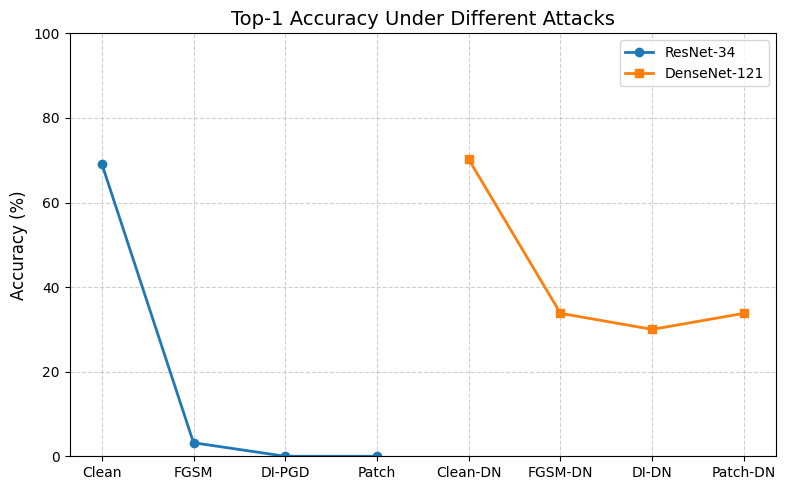

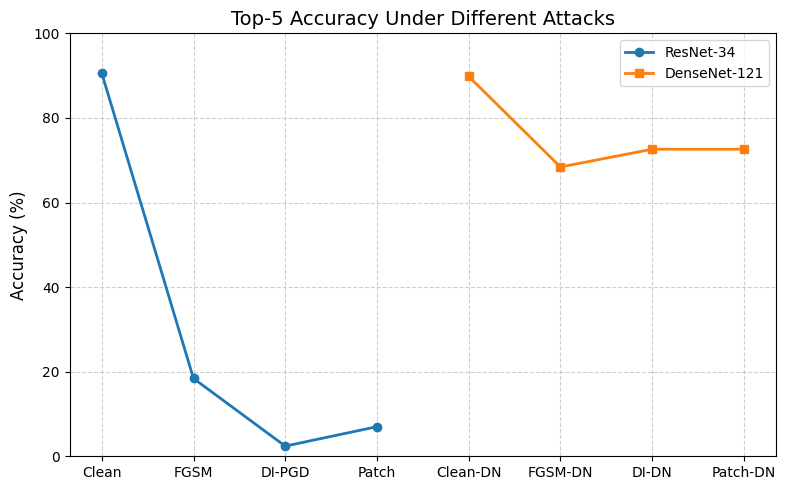

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Build a results dict from your computed accuracies ---
# (Replace these variable names with the ones in your notebook if different)
results = {
    'Clean':   (c1_1, c1_5),
    'FGSM':    (a1_1, a1_5),
    'DI‑PGD':  (b2_1, b2_5),
    'Patch':   (c3_1, c3_5),
    'Clean-DN':(d0_1, d0_5),
    'FGSM-DN': (d1_1, d1_5),
    'DI-DN':   (d2_1, d2_5),
    'Patch-DN':(d3_1, d3_5),
}

# x‑axis labels
labels    = ['Clean', 'FGSM', 'DI‑PGD', 'Patch']
labelsdn = ['Clean-DN', 'FGSM-DN', 'DI-DN', 'Patch-DN']

# Extract Top‑1 and Top‑5 (in %)
top1_r34 = [results[l][0]*100 for l in labels]
top5_r34 = [results[l][1]*100 for l in labels]

top1_dn  = [results[l][0]*100 for l in labelsdn]
top5_dn  = [results[l][1]*100 for l in labelsdn]

# --- Top‑1 Accuracy plot ---
plt.figure(figsize=(8,5))
plt.plot(labels, top1_r34, marker='o', linewidth=2, label='ResNet‑34')
plt.plot(labelsdn, top1_dn,  marker='s', linewidth=2, label='DenseNet‑121')
plt.title("Top‑1 Accuracy Under Different Attacks", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Top‑5 Accuracy plot ---
plt.figure(figsize=(8,5))
plt.plot(labels, top5_r34, marker='o', linewidth=2, label='ResNet‑34')
plt.plot(labelsdn, top5_dn,  marker='s', linewidth=2, label='DenseNet‑121')
plt.title("Top‑5 Accuracy Under Different Attacks", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


### Trends and Insights

- Multi-step attacks like DI‑PGD are extremely potent, completely collapsing model accuracy while also transferring well to other architectures.
- FGSM, though fast and simple, causes a severe drop in Top-1 accuracy (from 69.2% to 3.2%) on ResNet-34 and moderately impacts DenseNet-121.
- Patch-RS attacks, despite being localized, were highly disruptive — completely breaking ResNet-34 and transferring surprisingly well to DenseNet.
- Clean accuracy (~69–70% Top‑1) provides no assurance of robustness — both ResNet-34 and DenseNet-121 showed dramatic accuracy degradation with modest perturbations.

---

### Key Observations

| Attack       | ResNet-34 Top‑1 | ResNet-34 Top‑5 | DenseNet-121 Top‑1 | DenseNet-121 Top‑5 |
|--------------|------------------|------------------|----------------------|----------------------|
| Clean        | 69.20%           | 90.60%           | 70.20%               | 89.80%               |
| FGSM         | 3.20%            | 18.40%           | 33.80%               | 68.40%               |
| DI‑PGD       | 0.00%            | 2.40%            | 30.00%               | 72.60%               |
| Patch-RS     | 0.00%            | 7.00%            | 33.80%               | 72.60%               |

- DI‑PGD completely nullifies classification capability on ResNet-34.
- FGSM still allows some recovery in DenseNet, though with major accuracy losses.
- Surprisingly, Patch-RS attacks, despite being localized, transfer nearly as well as DI‑PGD.
- Top-5 accuracy also collapses under all attacks, highlighting their severity.

---

### Inference

- DI-PGD outperforms other attack types in both effectiveness and transferability, even degrading DenseNet-121 performance significantly.
- FGSM shows that even basic adversarial methods are enough to render models unreliable under adversarial threat.
- Patch-based attacks highlight model sensitivity to spatially localized perturbations — especially when targeting salient regions.
- Even high Top-5 accuracy under clean conditions doesn’t imply resilience; models are vulnerable across multiple fronts.

---

### Learnings

- Input diversity and iteration (DI‑PGD) amplify adversarial success and should be focal points in attack/defense research.
- Transferability across architectures remains a serious concern — defenses must consider cross-model generalization of attacks.
- Patch attacks are valuable for simulating real-world occlusions and demonstrate robustness shortcomings in vision models.
- A model’s clean accuracy should never be interpreted as a proxy for robustness — comprehensive evaluations under threat models are essential.
